# Tumor detection with volumetric segmentation models

This notebook serves as an example of training models available in this package on MRI scans in order to detect brain tumors. It makes use of the <i>Brain MRI segmentation</i> which is available [here](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation?resource=download). For this notebook to work out of the box, the folders containing images and masks should be placed in volumetric_segmentation/data/kaggle_3m. You can download the zip manually or using the download_and_prepare_data.sh script.

In [3]:
from volseg.unet_3d.model import UNet3d
from volseg.example.brain_mri_dataset import BrainMRIDataset
from volseg.loss.dice import DiceLoss
from volseg.utils.image_dimension_wrapper import ImageDimensionsWrapper

from sklearn.model_selection import train_test_split

import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import sys
import tqdm

## Data

Run the following cells in order to check if the data was downloaded and placed correctly. In case it does not live in the recommended folder, change data_root. In the end, perform train/val split.

In [4]:
data_root = "./volumetric_segmentation/data/kaggle_3m"

In [5]:
mri_folders = sorted([it for it in os.listdir(data_root) if "." not in it])  # omit any non-folders, e.g. README.md 
len(mri_folders)

110

In [6]:
train_folders, val_folders = train_test_split(mri_folders, test_size=0.1, random_state=1337)
len(train_folders), len(val_folders)

(99, 11)

## Data preparation

PyTorch works in a channel-first mode, thus the dimensions provided to ImageDimensionsWrapper are in (channels, depth, height/width) format. ImageDimensionsWrapper is an object made out of convenience: sometimes one does not need the number of channels and may call wrapper.get_dhw() to get a tuple of (depth, height, width). wrapper.get() returns full dimensions.

BrainMRIDataset is a dataset created specially for this tutorial. The autoscale parameter indicates whether we want to compute pixels' mean and standard deviation upon instantiation. Scaling the pixel images as follows usually improves training results:

$$pix' = \frac{pix - \mu}{s_x}$$

In [7]:
image_dimensions = ImageDimensionsWrapper((3, 96, 128, 128))

In [8]:
train_set_viz = BrainMRIDataset(data_root, train_folders, reshape_dhw=image_dimensions.get_dhw(), cache_loaded_images=False)  # Unnormalized train set used for image visualization

train_set = BrainMRIDataset(data_root, train_folders, reshape_dhw=image_dimensions.get_dhw(), cache_loaded_images=True, autoscale=True, autoscale_using_n_images=50, seed=3)
val_set = BrainMRIDataset(data_root, val_folders, reshape_dhw=image_dimensions.get_dhw(), cache_loaded_images=True)

INFO: Calculating mean


100%|██████████| 50/50 [00:53<00:00,  1.08s/it]


INFO: Calculating standard deviation


100%|██████████| 50/50 [05:43<00:00,  6.86s/it]


## Image and mask visualization

The below images show examples from the training and validation sets. Masks are overlayed on the red channel. As one may notice, the tumors' shapes and sizes vary significantly.

In [9]:
def visualize_mri(mri):
    image, mask, folder = mri
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(f"Folder name: {folder}")
    for r in range(2):
        for c in range(2):
            idx = 15 * (2 * r + c + 1)
            image[0, idx, :, :] = np.where(mask[idx, :, :] > 0, 255, image[0, idx, :, :])
            im_slice = np.moveaxis(image[:, idx, :, :], 0, -1)
            axs[r][c].imshow(im_slice)

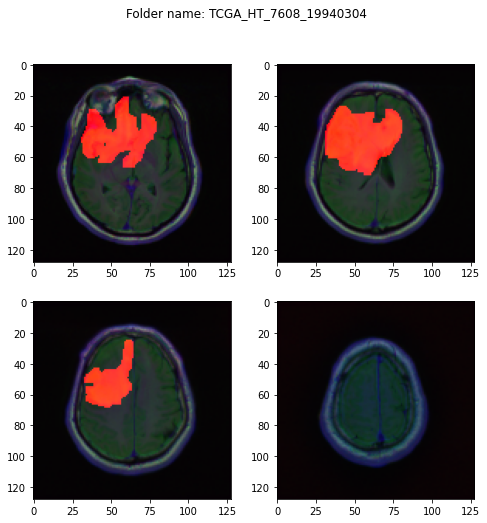

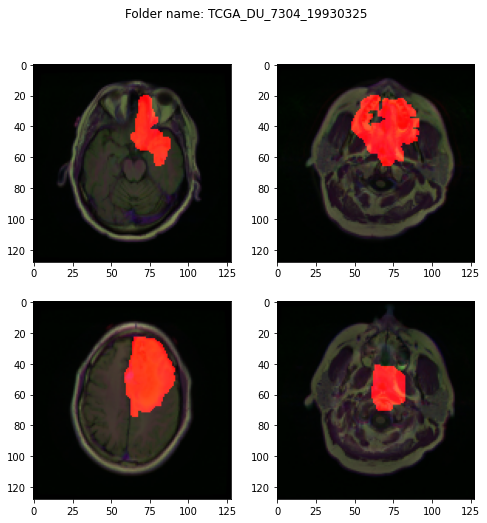

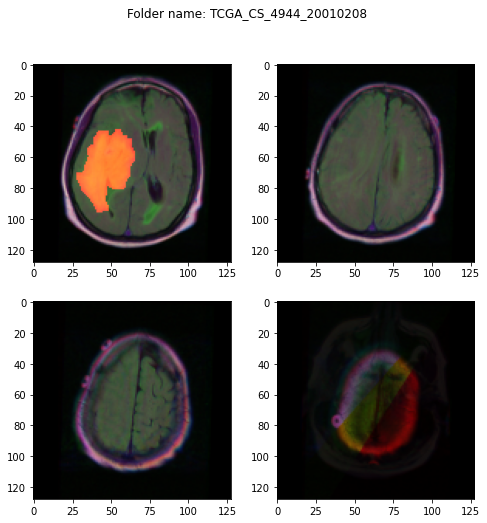

In [10]:
visualize_mri(train_set_viz[10])
visualize_mri(train_set_viz[25])
visualize_mri(train_set_viz[50])

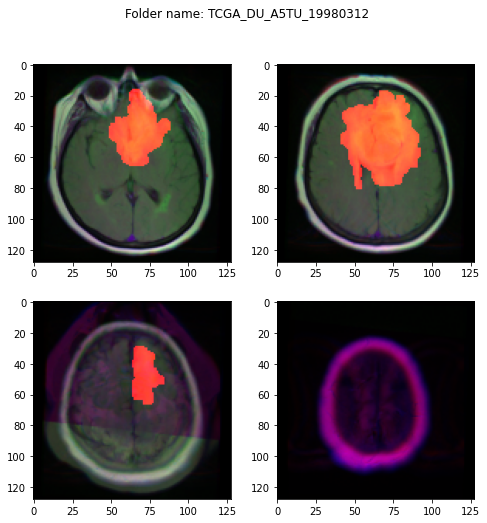

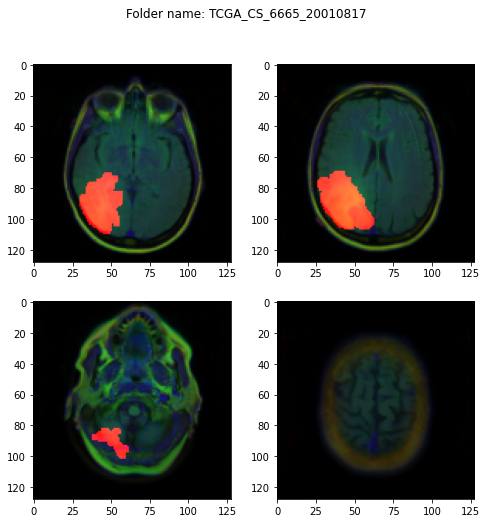

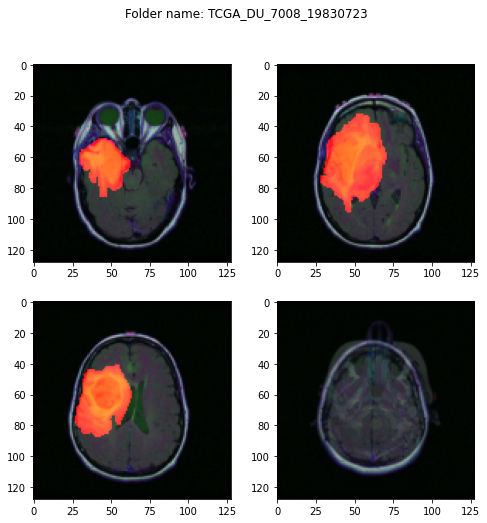

In [11]:
visualize_mri(val_set[3])
visualize_mri(val_set[6])
visualize_mri(val_set[9])

## Model preparation and training

Neural networks benefit greatly from the possibility of using a GPU for training and inference. The below line checks if a GPU is available and uses it if that is the case.

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Instantiate the model and training parameters. Below we will use the 3D U-Net, as it is computationally less expensive than V-Net.

In [13]:
model = UNet3d(num_classes=1, image_dimensions=image_dimensions).to(device)

In [14]:
epochs = 150
batch_size = 2
terminate_after_no_improvement_epochs = 10
criterion = DiceLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

Main training loop:

In [16]:
training_history = []
validation_history = []

best_loss = float("inf")
best_epoch = None
best_state_dict = None

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}")
    total_training_loss = 0.0
    for batch_number, data in tqdm.tqdm(enumerate(train_loader, start=1), total=len(train_loader)):
        inputs, labels, _ = data

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_training_loss += loss.item()
    training_loss = total_training_loss / len(train_set)
    training_history.append(training_loss)
    print(f'[Training loss: {training_loss:.3f}')

    total_validation_loss = 0.0
    with torch.no_grad():
        for batch_number, data in tqdm.tqdm(enumerate(val_loader, start=1), total=len(val_loader)):
            inputs, labels, _ = data
            inputs = (inputs - train_set.mean) / train_set.stdev

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs.float())

            total_validation_loss += criterion(outputs, labels).item()
    validation_loss = total_validation_loss / len(val_set)
    validation_history.append(validation_loss)
    print(f'[Validation loss: {validation_loss:.3f}')

    if validation_loss < best_loss:
        best_epoch = epoch
        best_loss = validation_loss
        best_state_dict = model.state_dict().copy()
        torch.save(best_state_dict, "./best_weights.pth")
    elif terminate_after_no_improvement_epochs is not None:
        epochs_without_improvement = epoch - best_epoch
        if epochs_without_improvement >= terminate_after_no_improvement_epochs:
            print(f"Stopping training after {epoch} epochs")
            break

Epoch 1


100%|██████████| 50/50 [03:22<00:00,  4.04s/it]

[Training loss: 0.476



100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

[Validation loss: 0.502
Epoch 2



100%|██████████| 50/50 [03:22<00:00,  4.04s/it]

[Training loss: 0.454



100%|██████████| 6/6 [00:16<00:00,  2.74s/it]

[Validation loss: 0.475
Epoch 3



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.410



100%|██████████| 6/6 [00:15<00:00,  2.58s/it]

[Validation loss: 0.416
Epoch 4



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.369



100%|██████████| 6/6 [00:15<00:00,  2.52s/it]

[Validation loss: 0.420
Epoch 5



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.347



100%|██████████| 6/6 [00:15<00:00,  2.51s/it]

[Validation loss: 0.370
Epoch 6



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.345



100%|██████████| 6/6 [00:15<00:00,  2.56s/it]

[Validation loss: 0.356
Epoch 7



100%|██████████| 50/50 [03:21<00:00,  4.04s/it]

[Training loss: 0.348



100%|██████████| 6/6 [00:15<00:00,  2.61s/it]

[Validation loss: 0.406
Epoch 8



100%|██████████| 50/50 [03:22<00:00,  4.04s/it]

[Training loss: 0.348



100%|██████████| 6/6 [00:16<00:00,  2.71s/it]

[Validation loss: 0.377
Epoch 9



100%|██████████| 50/50 [03:21<00:00,  4.04s/it]

[Training loss: 0.347



100%|██████████| 6/6 [00:15<00:00,  2.55s/it]

[Validation loss: 0.351
Epoch 10



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.334



100%|██████████| 6/6 [00:15<00:00,  2.57s/it]

[Validation loss: 0.367
Epoch 11



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.336



100%|██████████| 6/6 [00:15<00:00,  2.66s/it]

[Validation loss: 0.345
Epoch 12



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.333



100%|██████████| 6/6 [00:15<00:00,  2.56s/it]

[Validation loss: 0.379
Epoch 13



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.329



100%|██████████| 6/6 [00:16<00:00,  2.72s/it]

[Validation loss: 0.333
Epoch 14



100%|██████████| 50/50 [03:20<00:00,  4.01s/it]

[Training loss: 0.313



100%|██████████| 6/6 [00:15<00:00,  2.63s/it]

[Validation loss: 0.354
Epoch 15



100%|██████████| 50/50 [03:24<00:00,  4.08s/it]

[Training loss: 0.311



100%|██████████| 6/6 [00:16<00:00,  2.70s/it]

[Validation loss: 0.319
Epoch 16



100%|██████████| 50/50 [03:20<00:00,  4.02s/it]

[Training loss: 0.317



100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

[Validation loss: 0.320
Epoch 17



100%|██████████| 50/50 [03:21<00:00,  4.04s/it]

[Training loss: 0.309



100%|██████████| 6/6 [00:16<00:00,  2.67s/it]

[Validation loss: 0.323
Epoch 18



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.315



100%|██████████| 6/6 [00:14<00:00,  2.48s/it]

[Validation loss: 0.346
Epoch 19



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.308



100%|██████████| 6/6 [00:16<00:00,  2.73s/it]

[Validation loss: 0.317
Epoch 20



100%|██████████| 50/50 [03:21<00:00,  4.02s/it]

[Training loss: 0.305



100%|██████████| 6/6 [00:15<00:00,  2.58s/it]

[Validation loss: 0.336
Epoch 21



100%|██████████| 50/50 [03:22<00:00,  4.04s/it]

[Training loss: 0.296



100%|██████████| 6/6 [00:14<00:00,  2.50s/it]

[Validation loss: 0.308
Epoch 22



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.314



100%|██████████| 6/6 [00:15<00:00,  2.58s/it]

[Validation loss: 0.326
Epoch 23



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.311



100%|██████████| 6/6 [00:15<00:00,  2.64s/it]

[Validation loss: 0.317
Epoch 24



100%|██████████| 50/50 [03:21<00:00,  4.02s/it]

[Training loss: 0.299



100%|██████████| 6/6 [00:16<00:00,  2.72s/it]

[Validation loss: 0.313
Epoch 25



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.298



100%|██████████| 6/6 [00:15<00:00,  2.62s/it]

[Validation loss: 0.310
Epoch 26



100%|██████████| 50/50 [03:20<00:00,  4.02s/it]

[Training loss: 0.304



100%|██████████| 6/6 [00:15<00:00,  2.63s/it]

[Validation loss: 0.312
Epoch 27



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.287



100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

[Validation loss: 0.305
Epoch 28



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.301



100%|██████████| 6/6 [00:15<00:00,  2.57s/it]

[Validation loss: 0.306
Epoch 29



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.293



100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

[Validation loss: 0.303
Epoch 30



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.298



100%|██████████| 6/6 [00:15<00:00,  2.65s/it]

[Validation loss: 0.303
Epoch 31



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.299



100%|██████████| 6/6 [00:15<00:00,  2.52s/it]

[Validation loss: 0.302
Epoch 32



100%|██████████| 50/50 [03:21<00:00,  4.04s/it]

[Training loss: 0.290



100%|██████████| 6/6 [00:15<00:00,  2.58s/it]

[Validation loss: 0.303
Epoch 33



100%|██████████| 50/50 [03:21<00:00,  4.04s/it]

[Training loss: 0.296



100%|██████████| 6/6 [00:15<00:00,  2.54s/it]

[Validation loss: 0.302
Epoch 34



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.297



100%|██████████| 6/6 [00:15<00:00,  2.58s/it]

[Validation loss: 0.299
Epoch 35



100%|██████████| 50/50 [03:22<00:00,  4.06s/it]

[Training loss: 0.292



100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

[Validation loss: 0.296
Epoch 36



100%|██████████| 50/50 [03:22<00:00,  4.04s/it]

[Training loss: 0.284



100%|██████████| 6/6 [00:15<00:00,  2.58s/it]

[Validation loss: 0.302
Epoch 37



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.281



100%|██████████| 6/6 [00:15<00:00,  2.66s/it]

[Validation loss: 0.325
Epoch 38



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

[Training loss: 0.290



100%|██████████| 6/6 [00:15<00:00,  2.55s/it]

[Validation loss: 0.298
Epoch 39



100%|██████████| 50/50 [03:21<00:00,  4.04s/it]

[Training loss: 0.290



100%|██████████| 6/6 [00:15<00:00,  2.62s/it]

[Validation loss: 0.307
Epoch 40



100%|██████████| 50/50 [03:21<00:00,  4.04s/it]

[Training loss: 0.282



100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

[Validation loss: 0.307
Epoch 41



100%|██████████| 50/50 [03:23<00:00,  4.06s/it]

[Training loss: 0.288



100%|██████████| 6/6 [00:15<00:00,  2.62s/it]

[Validation loss: 0.301
Epoch 42



100%|██████████| 50/50 [03:22<00:00,  4.06s/it]

[Training loss: 0.278



100%|██████████| 6/6 [00:14<00:00,  2.48s/it]

[Validation loss: 0.309
Epoch 43



100%|██████████| 50/50 [03:23<00:00,  4.07s/it]

[Training loss: 0.290



100%|██████████| 6/6 [00:15<00:00,  2.56s/it]

[Validation loss: 0.303
Epoch 44



100%|██████████| 50/50 [03:21<00:00,  4.04s/it]

[Training loss: 0.270



100%|██████████| 6/6 [00:15<00:00,  2.58s/it]

[Validation loss: 0.302
Epoch 45



100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

[Training loss: 0.277



100%|██████████| 6/6 [00:15<00:00,  2.51s/it]

[Validation loss: 0.307
Stopping training after 45 epochs


## Results

In [18]:
def plot_losses(training_history, validation_history):
    plt.figure(figsize=(10, 5))
    x = range(1, len(training_history) + 1)
    plt.plot(x, training_history, "-.bx", x, validation_history, "-.rx")
    plt.legend(["Training loss", "Validation loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Dice loss")
    plt.show()

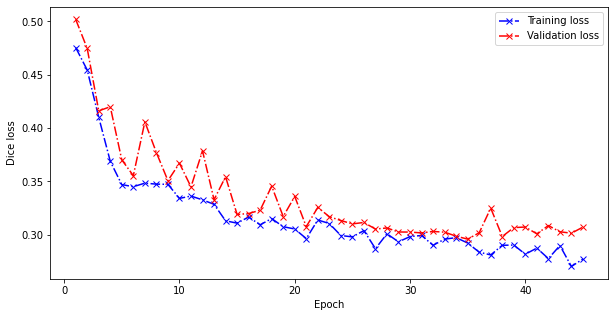

In [19]:
plot_losses(training_history, validation_history)

In [20]:
model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [21]:
def visualize_predictions(image, mask, pred, folder):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(f"Folder name: {folder}")
    for r in range(2):
        for c in range(2):
            idx = 10 * (2 * r + c + 1)
            image[0, idx, :, :] = np.where(mask[idx, :, :] > 0, 255, image[0, idx, :, :])
            image[1, idx, :, :] = np.where(pred[0, 0, idx, :, :] > 0.5, 255, image[1, idx, :, :])
            im_slice = np.moveaxis(image[:, idx, :, :], 0, -1)
            axs[r][c].imshow(im_slice)

<b><font color="red">Red</font></b> indicates ground truth masks while <b><font color="green">green</font></b> shows model predictions. <b><font color="#8B8000">Yellow</font></b> are places where the two overlap. The model seems to do a good job in identifying tumors, however proper segmentation is much more difficult. This would not be sufficient had this been more than a PoC. To improve results, one could take the following steps:
- pretrain the model on a different, larger dataset + use transfer learning / fine-tuning
- add data augmentation
- increase input image size
- use synthetic data

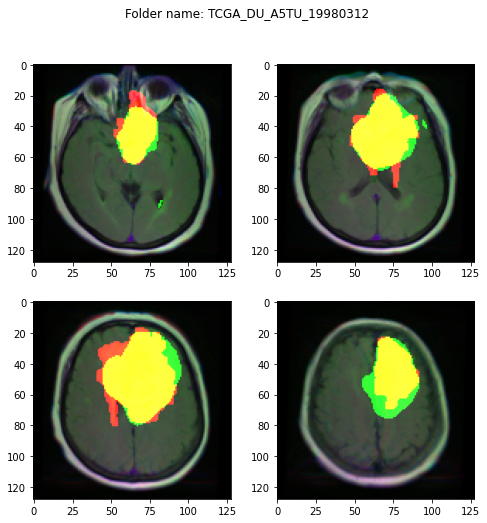

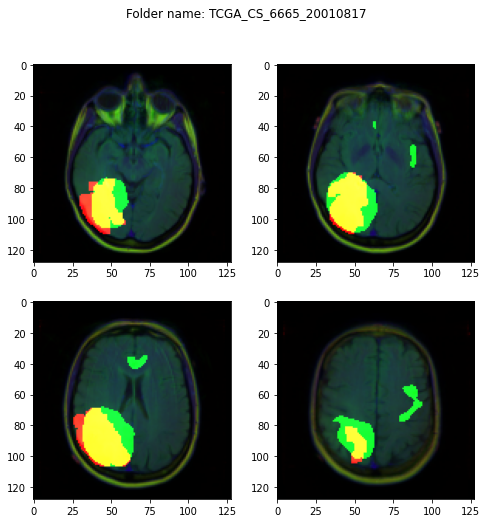

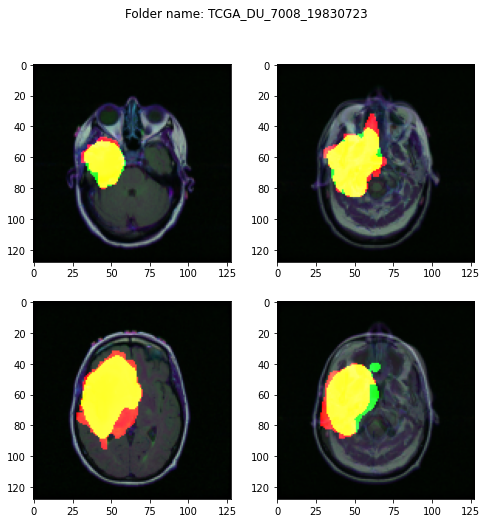

In [22]:
for i in range(3, 10, 3):
    image, mask, folder, = val_set[i]
    input_ = torch.from_numpy(image).to(device)
    input_ = torch.unsqueeze((input_ - train_set.mean) / train_set.stdev, dim=0)
    output = model(input_.float()).cpu()
    visualize_predictions(image, mask, output, folder)
    torch.cuda.empty_cache()